In [59]:
import os
import re
import datetime
import tempfile
from collections import Counter
import functools
import itertools
import sys

import numpy as np
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
from scipy import interp
import pandas as pd
pd.set_option('display.max_columns', 250)
# Don't cut off long string
# http://stackoverflow.com/questions/26277757/pandas-to-html-truncates-string-contents
pd.set_option('display.max_colwidth', -1)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.path as mpath
Path = mpath.Path
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
# matplotlib.style.use('ggplot')
matplotlib.style.use('classic')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16, 9)

from IPython.display import display, Image, HTML

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
kappa_scorer = metrics.make_scorer(metrics.cohen_kappa_score)


# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
TARGET_GENES = []
with open('/projects/trans_scratch/validations/workspace/szong/python_study/2D_hierarchical_clustering/target_genes.txt') as inf:
    for line in inf:
        TARGET_GENES.append(line.strip())

In [61]:
TARGET_GENES[:5]

['ABL1', 'AKT1', 'AKT2', 'ALK', 'AMER1']

In [62]:
old2new_gene_names_dd = {
#     'RTCD1': 'RTCA',  # so in the intogen case, they've used the newly RTCA
                         'FAM123B': 'AMER1', 'MYCL1': 'MYCL', 'MLL': 'KMT2A'}

In [63]:
new2old_gene_names_dd = dict([(j, i) for (i, j) in old2new_gene_names_dd.items()])

In [64]:
new2old_gene_names_dd

{'AMER1': 'FAM123B', 'KMT2A': 'MLL', 'MYCL': 'MYCL1'}

In [65]:
TARGET_GENES = [new2old_gene_names_dd.get(_, _) for _ in TARGET_GENES]

In [66]:
df_jw = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/python_study/2D_hierarchical_clustering/april_21_2017_gene_table_5_27pm.tsv', sep='\t', keep_default_na=False)

In [67]:
df_jw.head(2)

,Gene,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,KICH,KIRC,KIRP,LAML,LGG,LIHC,LUAD,LUSC,MESO,OV,PAAD,PCPG,PRAD,READ,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM
ABL1,O,,M,OU M,M,OU M,O,O M,OU M,OU M,O,OU M,M,O FM,,O M,OU M,OU M,,,,,OU M,OU M,OU,O M,O M,,OU M,,OU M,OU,,
AKT1,,M,M,M,M,M,,M,OU M,M,,M,,O,M,M,M,M,,,,,M,M,M,M,M,,M,M,M,,,


In [68]:
res = []
with open('/projects/trans_scratch/validations/workspace/szong/python_study/2D_hierarchical_clustering/april_21_2017_gene_table_5_27pm.tsv', 'rt') as inf:
    for k, line in enumerate(inf):
        if k == 0:
            cols = line.strip('\n').split('\t')
        else:
            res.append(line.strip('\n').strip('\t').split('\t'))

In [69]:
df_jw = pd.DataFrame(res, columns=cols)

In [70]:
df_jw.set_index('Gene', drop=True, inplace=True)

In [71]:
df_jw.head(2)

,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,KICH,KIRC,KIRP,LAML,LGG,LIHC,LUAD,LUSC,MESO,OV,PAAD,PCPG,PRAD,READ,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ABL1,O,,M,OU M,M,OU M,O,O M,OU M,OU M,O,OU M,M,O FM,,O M,OU M,OU M,,,,,OU M,OU M,OU,O M,O M,,OU M,,OU M,OU,
AKT1,,M,M,M,M,M,,M,OU M,M,,M,,O,M,M,M,M,,,,,M,M,M,M,M,,M,M,M,,


In [72]:
print(np.unique(df_jw.astype(str).values.ravel()).tolist())

['    ', '   M', '  F ', '  FM', ' U  ', ' U M', 'O   ', 'O  M', 'O FM', 'OU  ', 'OU M', 'OUFM']


In [73]:
# char_code = 'MOUF'
# char_code = 'FOUM'
char_code = 'FMOU'

In [74]:
str_codes = [''.join(_) for _ in list(itertools.product(*['{0}-'.format(_) for _ in char_code]))]

In [75]:
str_codes

['FMOU',
 'FMO-',
 'FM-U',
 'FM--',
 'F-OU',
 'F-O-',
 'F--U',
 'F---',
 '-MOU',
 '-MO-',
 '-M-U',
 '-M--',
 '--OU',
 '--O-',
 '---U',
 '----']

In [76]:
# http://stackoverflow.com/questions/8928240/convert-base-2-binary-number-string-to-int
int_codes = [int(''.join(_), 2) for _ in list(itertools.product('10', '10', '10', '10'))]

In [77]:
int_codes

[15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [78]:
str2int_dd = dict(zip(str_codes, int_codes))
int2str_dd = dict(zip(str_codes, int_codes))

In [79]:
# str2int_dd

In [80]:
def convert2binvec(s):
    """convert to binary vector"""
    res = []
    for i in char_code:
        res.append(1 if i in s else 0)
    return res

# assert convert2binvec('OU M') == [1, 1, 0, 1]

In [81]:
ndf = df_jw.applymap(convert2binvec)

In [82]:
ndf.head(2)

,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,KICH,KIRC,KIRP,LAML,LGG,LIHC,LUAD,LUSC,MESO,OV,PAAD,PCPG,PRAD,READ,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ABL1,"[0, 0, 1, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 1, 1]","[0, 1, 0, 0]","[0, 1, 1, 1]","[0, 0, 1, 0]","[0, 1, 1, 0]","[0, 1, 1, 1]","[0, 1, 1, 1]","[0, 0, 1, 0]","[0, 1, 1, 1]","[0, 1, 0, 0]","[1, 1, 1, 0]","[0, 0, 0, 0]","[0, 1, 1, 0]","[0, 1, 1, 1]","[0, 1, 1, 1]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 1, 1]","[0, 1, 1, 1]","[0, 0, 1, 1]","[0, 1, 1, 0]","[0, 1, 1, 0]","[0, 0, 0, 0]","[0, 1, 1, 1]","[0, 0, 0, 0]","[0, 1, 1, 1]","[0, 0, 1, 1]","[0, 0, 0, 0]"
AKT1,"[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 1, 1]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 1, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]"


# cluster by genes

In [83]:
data_mat = ndf.apply(lambda row: np.concatenate(row.values).tolist(), axis=1).values

In [84]:
type(data_mat)

numpy.ndarray

In [85]:
data_mat[:2]

array([ [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=object)

In [86]:
data_mat.shape

(114,)

In [87]:
# convert to 2D array
data = np.array(data_mat.tolist())

In [88]:
type(data)

numpy.ndarray

In [89]:
data.dtype

dtype('int64')

In [90]:
assert 33 * 4 == 132

In [91]:
Z_by_gene = linkage(data, metric='hamming')

In [92]:
# _ = dendrogram(Z_by_gene, labels=ndf.index.values)

In [93]:
gene_idxes = leaves_list(Z_by_gene)


# clustering by diseases

In [94]:
data_mat = ndf.apply(lambda row: np.concatenate(row.values).tolist()).values



In [95]:
# convert to 2D array
data = np.array(data_mat.tolist())

In [96]:
assert 114 * 4 == 456

In [97]:
# Z_by_dise = linkage(data, metric='jaccard')
Z_by_dise = linkage(data, metric='hamming')

In [98]:
dise_idxes = leaves_list(Z_by_dise)

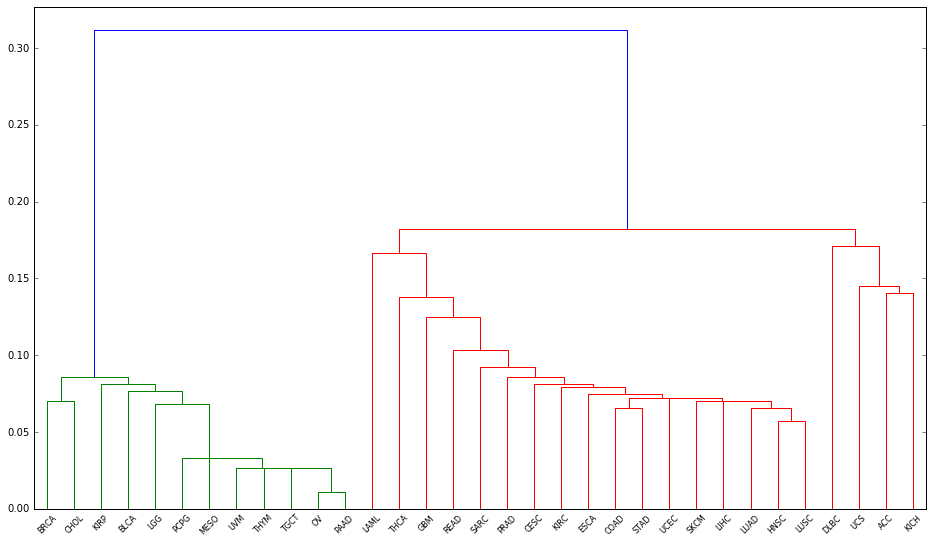

In [99]:
_ = dendrogram(Z_by_dise, labels=ndf.columns.values)

In [104]:
ndf.head()

,Gene,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,KICH,KIRC,KIRP,LAML,LGG,LIHC,LUAD,LUSC,MESO,OV,PAAD,PCPG,PRAD,READ,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM
0,ABL1,"[0, 0, 1, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 1, 1]","[0, 1, 0, 0]","[0, 1, 1, 1]","[0, 0, 1, 0]","[0, 1, 1, 0]","[0, 1, 1, 1]","[0, 1, 1, 1]","[0, 0, 1, 0]","[0, 1, 1, 1]","[0, 1, 0, 0]","[1, 1, 1, 0]","[0, 0, 0, 0]","[0, 1, 1, 0]","[0, 1, 1, 1]","[0, 1, 1, 1]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 1, 1]","[0, 1, 1, 1]","[0, 0, 1, 1]","[0, 1, 1, 0]","[0, 1, 1, 0]","[0, 0, 0, 0]","[0, 1, 1, 1]","[0, 0, 0, 0]","[0, 1, 1, 1]","[0, 0, 1, 1]","[0, 0, 0, 0]"
1,AKT1,"[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 1, 1]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 1, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]"
2,AKT2,"[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 1, 1]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 1, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 1, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]"
3,ALK,"[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 1, 0]","[1, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 1, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[1, 1, 1, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[1, 1, 0, 0]","[1, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[1, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[1, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]"
4,AMER1,"[0, 0, 1, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 1, 0]","[0, 0, 0, 0]","[0, 1, 1, 1]","[0, 1, 1, 0]","[0, 0, 1, 1]","[0, 0, 1, 0]","[0, 1, 1, 0]","[0, 0, 1, 0]","[0, 1, 1, 1]","[0, 0, 0, 0]","[0, 0, 1, 0]","[0, 0, 0, 0]","[0, 1, 1, 0]","[0, 1, 1, 1]","[0, 1, 1, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 1, 1]","[0, 0, 1, 1]","[0, 1, 1, 0]","[0, 1, 1, 1]","[0, 0, 0, 0]","[0, 0, 1, 1]","[0, 0, 0, 0]","[0, 1, 1, 0]","[0, 0, 1, 1]","[0, 0, 0, 0]"


In [102]:
# gene_idxes

array([  3,  90,  32,  17,  16,   2,  41,  33,   1,  18,  10, 112,  55,
        53,  22,  85,  67,  40,  39,   4, 111,  82,  80,  70,  62,  51,
       109, 106,  95,  77,  57,  72,  61,  60,  54,  52,  43,  24, 108,
       107, 102,  25,  21,  91,  56,  42,  30,  20,   6, 104, 101,  65,
        97,  88,  71,  34,  11,  31,  27,  12,  89,  75,  59,  36,  28,
        15, 103,  87,  14,  46,  73,  44,  38,  64, 113, 105,  98,  83,
        74,  79,  49,  96,  78,  66,  45,  35,  37, 110,  13,  48,  19,
         9,  81,   5,  94,  76,  47,   0, 100,  69,  63,   7,  58,  50,
        26,  99,  68,  93,  29,   8,  23,  84,  86,  92], dtype=int32)

In [105]:
# odf = ndf.ix[gene_idxes][dise_idxes]
ndf = ndf.reset_index()
ndf.columns = [i for i in range(ndf.shape[1])]
odf = ndf.loc[gene_idxes][dise_idxes]

In [108]:
odf = odf.set_index(1)

In [109]:
odf.head()

,2,4,12,14,21,18,32,29,27,19,20,13,28,8,23,24,22,3,11,7,5,26,30,25,15,16,9,17,6,31,0,10
1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ALK,"[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[1, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[1, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[1, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 1, 0]","[0, 1, 0, 0]","[1, 1, 0, 0]","[1, 1, 0, 0]","[0, 1, 0, 0]","[1, 1, 1, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]",3,"[0, 1, 1, 0]"
RTCA,"[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]",90,"[0, 0, 0, 0]"
FAS,"[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]",32,"[0, 0, 0, 0]"
CD47,"[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 1, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]",17,"[0, 0, 1, 1]"
CCNE1,"[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 1, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]",16,"[0, 1, 1, 0]"


AttributeError: '_LocIndexer' object has no attribute 'tolist'

# Convert to int for plotting

In [112]:
pdf = odf.applymap(lambda v: int(''.join(map(str, v)), 2))
pdf.head(2)

TypeError: ("'int' object is not iterable", 'occurred at index 0')

In [ ]:
uniq_vals = np.sort(np.unique(pdf.values))
uniq_vals

In [ ]:
qdf = pdf.T

In [ ]:
qdf.head()

In [ ]:
# assert qdf.values[0][0] == int('1000', 2)
# assert qdf.values[0][0] == qdf['ALK'].loc['BRCA']

In [ ]:
# print(len(xtick_labels))
# print(len(xticks))


In [3]:
# ax_by_gene.get_xticks()
ax_by_dise.get_yticks()

NameError: name 'ax_by_dise' is not defined

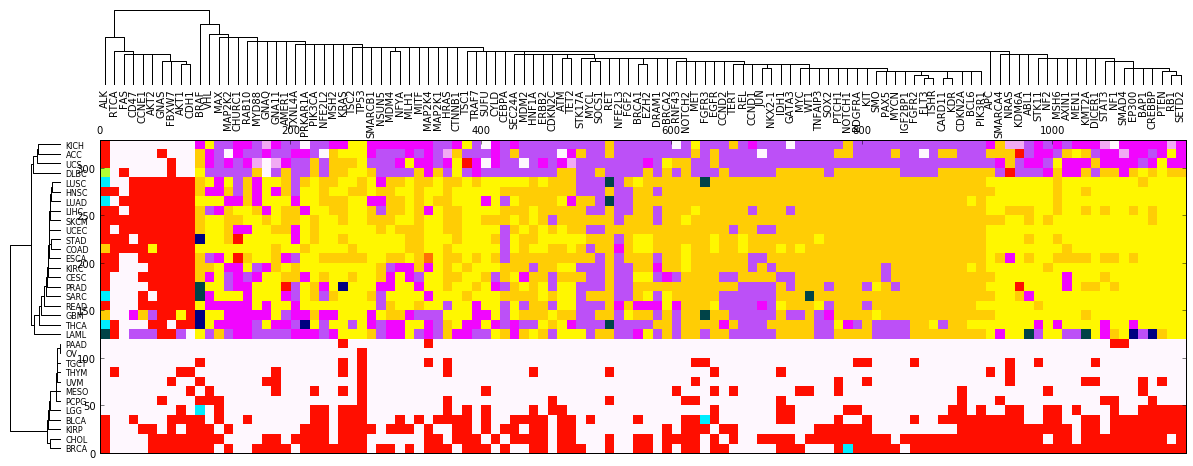

In [104]:
# http://stackoverflow.com/questions/24190858/matplotlib-move-ticklabels-between-ticks
fig = plt.figure(figsize=(22, 8), facecolor='white')

gs = gridspec.GridSpec(2, 3, height_ratios=[1,4], width_ratios=[1, 20, 0.2], 
                       wspace=0.1, # horizontal space
                       hspace=0.28  # vertical space
                      )

ax_by_gene = fig.add_subplot(gs[1])
col_func = lambda x: 'black'
_ = dendrogram(Z_by_gene, ax=ax_by_gene, labels=ndf.index.values, leaf_font_size=10, link_color_func=col_func)
ax_by_gene.set_frame_on(False)
ax_by_gene.axes.get_yaxis().set_visible(False)

ax_by_dise = fig.add_subplot(gs[3])
_ = dendrogram(Z_by_dise, ax=ax_by_dise, orientation='left', labels=ndf.columns.values,  link_color_func=col_func)
ax_by_dise.set_frame_on(False)
ax_by_dise.axes.get_xaxis().set_visible(False)

ax_mut = fig.add_subplot(gs[4])
ax_mut.xaxis.tick_top()
im = ax_mut.imshow(qdf.values,
                   origin='lower',
                   interpolation='none',
                   extent=list(ax_by_gene.get_xlim()) + list(ax_by_dise.get_ylim()),
                   aspect='auto',
                   cmap='gist_ncar_r', 
                   vmin=0, vmax=15)

In [103]:
# ticklabels follow major ticks
_ = ax_mut.set_xticks(ax_by_gene.get_xticks(), minor=False)
_ = ax_mut.set_yticks(ax_by_dise.get_yticks(), minor=False)
# ax_mut.minorticks_off()

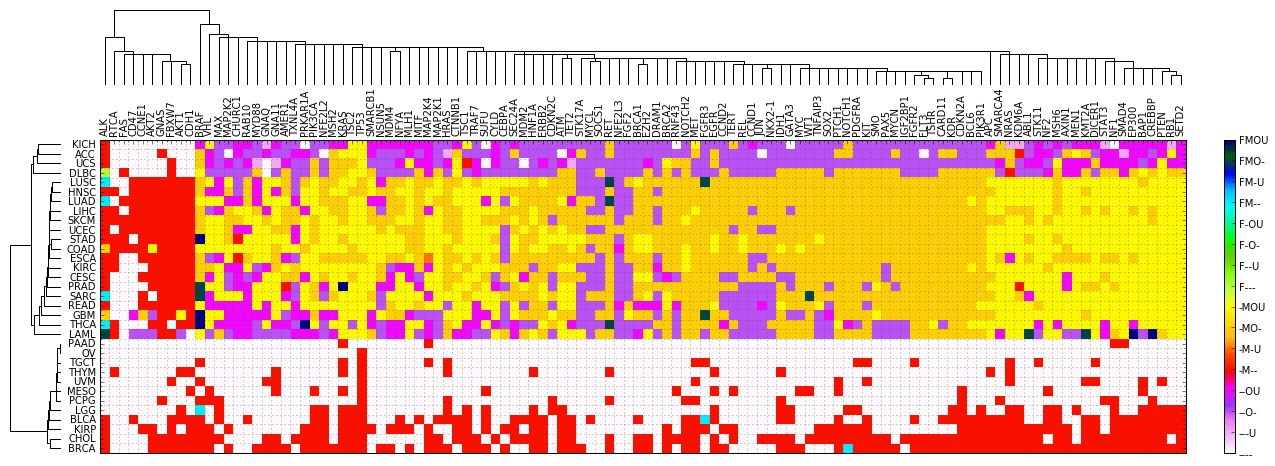

In [98]:
# http://stackoverflow.com/questions/14852821/aligning-rotated-xticklabels-with-their-respective-xticks
xtick_labels = qdf.columns.values.tolist()
ytick_labels = qdf.index.values.tolist()

# make sure the text match
assert xtick_labels == [_.get_text() for _ in ax_by_gene.get_xticklabels()]
assert ytick_labels == [_.get_text() for _ in ax_by_dise.get_yticklabels()]

ax_by_gene.set_xticklabels([])
ax_by_dise.set_yticklabels([])

_ = ax_mut.set_xticklabels(xtick_labels, rotation=90, ha='center')
_ = ax_mut.set_yticklabels(ytick_labels, va='center')

xticks = (ax_by_gene.get_xticks()[1:] + ax_by_gene.get_xticks()[:-1]) / 2
yticks = (ax_by_dise.get_yticks()[1:] + ax_by_dise.get_yticks()[:-1]) / 2
_ = ax_mut.set_xticks(xticks, minor=True)
_ = ax_mut.set_yticks(yticks, minor=True)
ax_mut.grid(color='green', which='minor')

ax_leg = fig.add_subplot(gs[5])
# ax_leg.set_frame_on(False)
# ax_leg.set_axis_off()
cb = fig.colorbar(im, cax=ax_leg)
# _ = cb.ax.set_yticklabels(str_codes)
_ = cb.set_ticks(int_codes)
_ = cb.set_ticklabels(str_codes)


for ax in [ax_by_gene, ax_by_dise, ax_mut, ax_leg]:
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(1)

# plt.savefig('./candidate_genes_mutational_profile_{0}.jpg'.format(char_code), 
#             dpi=200, bbox_inches='tight')

In [ ]:
# Legend:
# M=mutation
# F=Fusion
# O=over-expression
# U=under-expression

In [41]:
# Disease 	Corresponding COSMIC criteria 	Notes
# ACC 	adrenal_gland and adrenal_cortical_carcinoma 	 
# BLCA 	urinary_tract and bladder and transitional_cell_carcinoma 	 
# BRCA 	(breast and ductal carcinoma without _in_situ) or (breast and lobular carcinoma without _in_situ) 	Invasive implies it has expanded beyond the cancer origination so I removed entries that have in_situ. Loubular and different variation of ductal cancer are different types of invasive carcinoma based on this http://ww5.komen.org/AboutBreastCancer/DiagnosingBreastCancer/UnderstandingaDiagnosis/TumorTypesSizesGrades.html
# CESC 	(cervix and squamous_cell_carcinoma) or (cervix and endocervical_adenocarcinoma) or (cervix and mixed_adenosquamous_carcinoma) 	 
# CHOL 	biliary_tract and bile_duct and carcinoma 	 
# COAD 	large_intestine and colon and adenocarcinoma 	have not included colorectal hits if there is no COAD hits
# DLBC 	lymphoid_neoplasm and diffuse_large_B_cell_lymphoma 	 
# ESCA 	esophagus and carcinoma 	 
# GBM 	glioblastoma_multiforme 	 
# HNSC 	upper_aerodigestive_tract and head_neck and squamous_cell_carcinoma 	 
# KICH 	kidney and chromophobe 	 
# KIRC 	kidney and clear_cell_renal_cell_carcinoma 	 
# KIRP 	kidney and papillary_renal_cell_carcinoma 	 
# LAML 	acute_myeloid_leukaemia 	 
# LGG 	(brain and glioma and I) or (brain and glioma and II) 	 
# LIHC 	liver and hepatocellular_carcinoma 	 
# LUAD 	lung and adenocarcinoma 	 
# LUSC 	lung and squamous_cell_carcinoma 	 
# MESO 	mesothelioma 	 
# OV 	(ovary and serous_carcinoma) or (ovary and serous_adenoma) 	I cannot find terms in COSMIC entries that have cyst before adenoma or carcinoma
# PAAD 	pancreas and adenocarcinoma 	 
# PCPG 	pheochromocytoma or paraganglioma 	 
# PRAD 	prostate and adenocarcinoma 	 
# READ 	large_intestine and rectum and adenocarcinoma 	have not included colorectal hits if there is no READ hits
# SARC 	sarcoma 	contains endometrium (uterus) sarcoma
# SKCM 	skin and melanoma 	 
# STAD 	stomach and adenocarcinoma 	 
# TGCT 	testis and germ_cell_tumour 	 
# THCA 	thyroid and carcinoma 	 
# THYM 	thymus thymoma 	 
# UCEC 	endometrium and endometrioid_carcinoma 	No uterus entries in COSMIC's tissue category
# UCS 	(endometrium and carcinoma) or (endometrium and sarcoma) 	contains UCEC and contained within sarcoma
# UVM 	eye and uveal_tract and melanoma 	 

I have another suggestion, instead of trinary encoding. can you try binary encoding so as to distinguish all sorts of combinations, with hamming distance or Jaccard distance. Jaccard distance definition is very simple http://stats.stackexchange.com/questions/58706/distance-metrics-for-binary-vectors. But I actually prefer hamming, it's almost exactly for this kind of calculation. https://en.wikipedia.org/wiki/Hamming_distance, comparing two binary strings.

FYI, there are other binary distance metrics too, http://www.ibm.com/support/knowledgecenter/en/SSLVMB_21.0.0/com.ibm.spss.statistics.help/cmd_proximities_sim_measure_binary.htm.

As for distance between clusters, you could try a few, too, and see how they differ. I used this page to learn difference linkage measures. https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html